## Prep work

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
data_dir = '../trimmedData'

In [4]:
years = ['04', '06', '08', '12', '14', '16']

In [8]:
# PAC dataframe list
pdfl = []
# Individual dataframe list
idfl = []
for year in years:
    df = pd.read_csv(os.path.join(data_dir, '20{}p.csv'.format(year)))
    df['year'] = int('20' + year)
    pdfl.append(df)
    df = pd.read_csv(os.path.join(data_dir, '20{}i.csv'.format(year)))
    df['year'] = int('20' + year)
    idfl.append(df)
pdf = pd.concat(pdfl)
idf = pd.concat(idfl)
    

In [13]:
print(pdf.dtypes)
print(idf.dtypes)

CID       object
amount     int64
year       int64
dtype: object
CID        object
amount    float64
year        int64
dtype: object


## Calculate and Visualize total contributions

In [20]:
total_df = pd.concat([df, idf])
total_df.head()

,CID,amount,year
0,,1885568.0,2016
1,C00000059,3114.0,2016
2,C00000422,58656.0,2016
3,C00000638,11596.0,2016
4,C00000729,30655.0,2016


In [21]:
pac_cycle_total = pdf.groupby('year').sum()
ind_cycle_total = idf.groupby('year').sum()
cycle_total = total_df.groupby('year').sum()

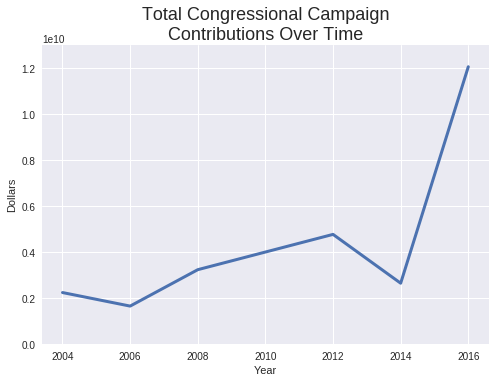

In [137]:
plt.style.use('seaborn')
plt.plot(cycle_total, lw=3)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.title("Total Congressional Campaign\nContributions Over Time", size=18)
plt.ylim([0, 1.3e10])
plt.xlabel("Year")
plt.ylabel("Dollars")
plt.savefig("q1-TotalContributions.png")

## Calculate total contributions per year per candidate; visualize distributions

In [44]:
years = [2004, 2006, 2008, 2012, 2014, 2016]
distributions = []
for year in years:
    distributions.append(total_df[total_df['year'] == year].groupby('CID')['amount'].sum())

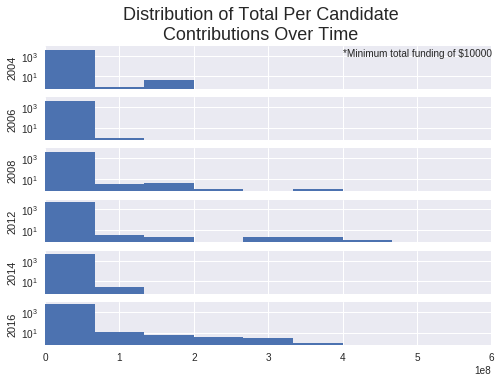

In [136]:
fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True)
plt.suptitle("Distribution of Total Per Candidate\nContributions Over Time", size=18)
for year, dist, ax in zip(years, distributions, axs):
    ax.hist([i for i in dist if (i > 10000 and i < 6e8)], bins=np.linspace(start=0, stop=6e8, num=10))
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlim([0, 6e8])
    ax.set_ylabel(year)
axs[0].annotate(xy=(400000000,1000), s="*Minimum total funding of $10000")
plt.savefig("q1-DistributionOfCandidateTotals.png")

## Calculate and Visualize the breakdown (individuals vs pacs)

In [131]:
ppl = []
ipl = []
for p, i, y in zip(pac_cycle_total['amount'], ind_cycle_total['amount'], years):
    total = p + i
    pp = p / total
    ip = i / total
    ppl.append(pp)
    ipl.append(ip)

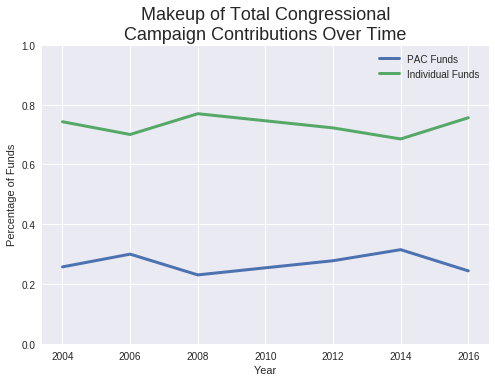

In [135]:
plt.plot(years, ppl, label="PAC Funds", lw=3)
plt.plot(years, ipl, label="Individual Funds", lw=3)
plt.title("Makeup of Total Congressional\nCampaign Contributions Over Time", size=18)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Percentage of Funds")
plt.ylim([0, 1])
plt.savefig("q1-MakeupOfTotalContributions.png")